### Overview

#### External Interface Requirements
1. Input requirement: capacity to read a dataset stored on disk.
2. Output requirement: report on optimal number of clusters, centroid coordinates and quality metric.
3. Output requirement: identifiers of classes corresponding to new instances classified by the model.

#### Functional Requirements
1. The software must learn a clusterization a the dataset.
2. The software must use the learned clusterization to classify new problem instances.
3. The software must evaluate the quality of a clusterization.
4. The software must be flexible to work with different preconfigured amount of clusters.
5. The software must compare results using different numbers of clusters and determine which number of clusters is best.


#### Necessary Deliverables
1. Python application that performs ETL, training, and testing.
2. Report containing quality metrics, and explanation of the dataset, and the experimental procedure (range of the different number of clusters that were tested, how the range was traversed, etc.).

#### Further notes
	- Find data & understand it (sometimes need to aggregate rows of data as each line is not unique) 
    - Perform data cleaning&feature engineering 
	- First find all different clusters (types) of clients/products 
	- 2nd find their characteristics 

In [883]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

import geopy.distance

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import silhouette_score 

from sklearn.decomposition import PCA 

from sklearn.cluster import DBSCAN 
from sklearn import mixture 

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

### Load data 

In [884]:
taxi = pd.read_csv('../data/train.csv')

### Exploring the data & variables

In [885]:
taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [886]:
taxi.shape

(1458644, 11)

In [887]:
taxi.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Convert pickup and drop off to datetime

In [888]:
taxi.pickup_datetime = pd.to_datetime(taxi.pickup_datetime)
taxi.dropoff_datetime = pd.to_datetime(taxi.dropoff_datetime)

In [889]:
taxi.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [890]:
missing = taxi.isnull().sum()
missing

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

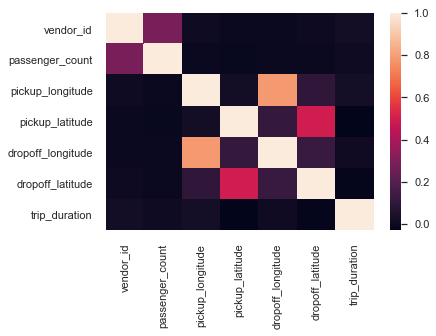

In [891]:
sns.heatmap(taxi.corr())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ce98f15f8>,
      dtype=object)

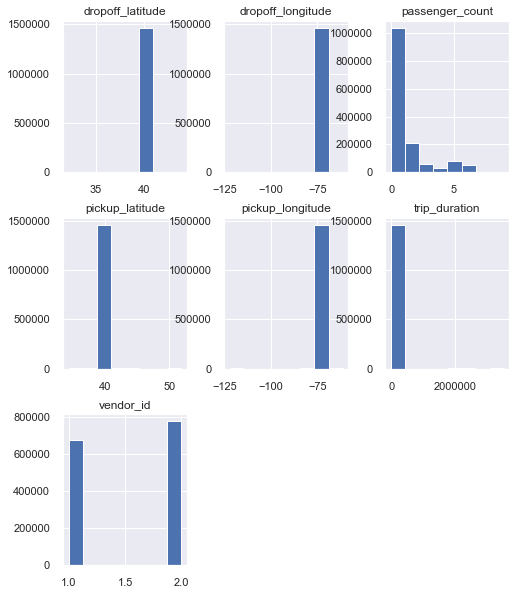

In [892]:
taxi.hist(figsize=(8,10), bins=8, color='b')

Plot boxplot for trip duration to check for outliers

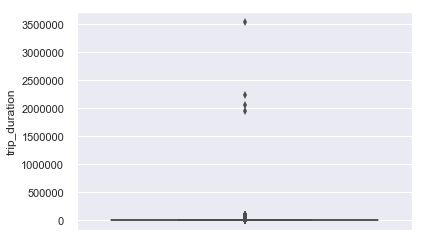

In [893]:
sns.boxplot(y='trip_duration', data=taxi, color='b')

In [894]:
taxi.trip_duration.min(), taxi.trip_duration.max()

(1, 3526282)

In [895]:
print('max hours: ' , 3526282/60/60)

max hours:  979.5227777777778


Check for any trips longer than 3 h

In [896]:
len(taxi[taxi.trip_duration > 10800])

2112

There are > 2000 rows with trip duration longer than 3h; will need to drop those  as outliers

Check values per vendor; might use this as a filter for subset

In [897]:
taxi.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

Check values per month of pickup; this could be a second filter for subset

In [898]:
taxi.pickup_datetime.map(lambda dt: dt.month).value_counts()

3    256189
4    251645
5    248487
2    238300
6    234316
1    229707
Name: pickup_datetime, dtype: int64

Choose only vendor 2 & month of January to create a subset from which we will take a sample to apply the model

In [899]:
subset = taxi[(taxi.vendor_id == 2) & (taxi.pickup_datetime.dt.month == 1)]

In [900]:
subset.shape

(124105, 11)

In [901]:
subset2 = subset.copy()

### Visualize the Data to Gain Insights

#### Exploring longitude & latitude

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


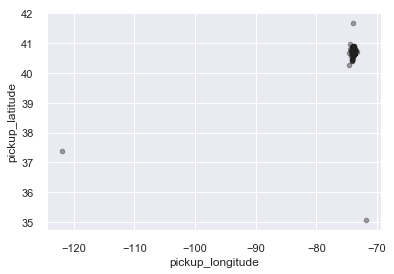

In [902]:
subset2.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4)

- Remove far away destinations to get more clarity on the data for trips that originated & terminated within New York
- The area of NYC we will focus is: latitude between 40.6285 and 40.8408, and longitude between -74.1831 and -73.7608

In [903]:
subset2 = subset2[(subset2.pickup_latitude > 40.6285) & 
        (subset2.pickup_latitude < 40.8408) &
        (subset2.pickup_longitude > -74.1831) & 
        (subset2.pickup_longitude < -73.7608) &
        (subset2.dropoff_latitude > 40.6285) & 
        (subset2.dropoff_latitude < 40.8408) &
        (subset2.dropoff_longitude > -74.1831) & 
        (subset2.dropoff_longitude < -73.7608)]

Also drop the rows with trip duration > 3h as outliers

In [904]:
subset2 = subset2[subset2.trip_duration < 10800]

Use a sample of 10k rows for clustering

In [905]:
df = subset2.sample(15000)

Plot pickup & drop off locations

In [906]:
map_= plt.imread('../NYC.png')

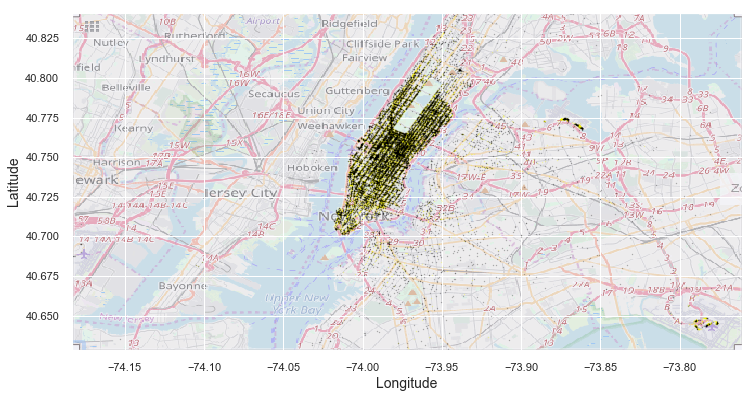

In [907]:
ax = df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4,
        figsize=(12,10), s = 0.1, color='yellow')
df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', alpha=0.4,
        figsize=(12,10), s = 0.1, color='black', ax=ax)

plt.imshow(map_, extent=[-74.1831, -73.7608, 40.6285, 40.8408], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

We can use this information to cluster NYC based on the taxi pickup & dropoff locations and then use this information for further clustering

Check trip duration distribution (convert seconds to hours for plotting purposes)

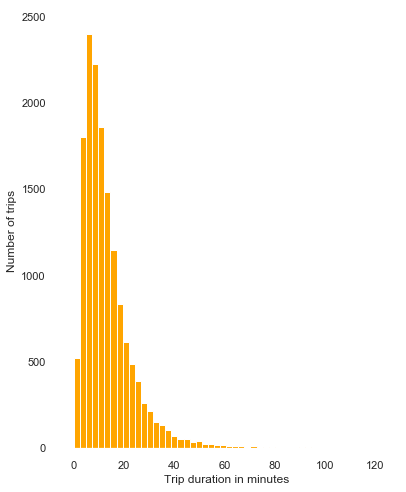

In [908]:
duration = df.trip_duration/60

plt.figure(figsize=(6,8))
ax = duration.hist(bins=50, color="orange")
ax.patch.set_facecolor('white')
plt.xlabel("Trip duration in minutes", fontsize=12)
plt.ylabel("Number of trips", fontsize=12)
plt.show()

In [909]:
df[df.trip_duration < 60]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1067186,id2198851,2,2016-01-19 20:00:08,2016-01-19 20:00:18,5,-73.981850,40.763439,-73.983498,40.761059,N,10
390630,id3683909,2,2016-01-21 11:40:38,2016-01-21 11:40:43,1,-73.982986,40.756538,-73.982986,40.756538,N,5
888814,id3215370,2,2016-01-13 22:32:34,2016-01-13 22:33:14,1,-74.011093,40.703583,-74.011543,40.703060,N,40
366421,id0877279,2,2016-01-01 11:46:35,2016-01-01 11:46:59,1,-74.010162,40.701969,-74.008629,40.702518,N,24
1102793,id2002808,2,2016-01-13 04:00:27,2016-01-13 04:01:05,1,-73.982880,40.756310,-73.980103,40.760540,N,38
573242,id0287018,2,2016-01-29 23:36:49,2016-01-29 23:37:26,2,-73.969620,40.761318,-73.971046,40.761662,N,37
985801,id1531959,2,2016-01-06 15:12:37,2016-01-06 15:12:46,1,-73.909637,40.751141,-73.909782,40.749641,N,9
1154637,id0935069,2,2016-01-06 04:39:00,2016-01-06 04:39:44,2,-73.955811,40.776531,-73.951042,40.782681,N,44
395708,id3214062,2,2016-01-02 09:07:12,2016-01-02 09:08:04,1,-73.936996,40.764618,-73.936981,40.764572,N,52
1371475,id2778914,2,2016-01-17 11:21:55,2016-01-17 11:22:01,3,-73.990143,40.763950,-73.989571,40.763710,N,6


### K-means clustering for neighbourhoods

Find the optimal number of clusters

In [910]:
df_coordinates = df.copy()

In [911]:
df.shape

(15000, 11)

Combine both pickup & dropoff latitudes & longitudes

In [912]:
combined = np.vstack((df_coordinates[['pickup_latitude', 'pickup_longitude']].values,
                    df_coordinates[['dropoff_latitude', 'dropoff_longitude']].values))

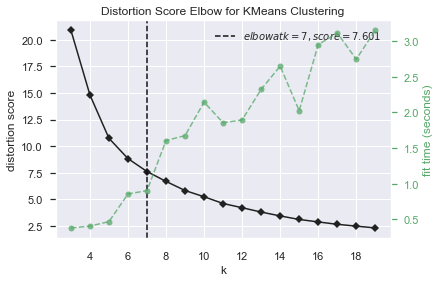

In [789]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20), metric='distortion')
visualizer.fit(combined)
visualizer.poof()

Apply the optimal number of clusters to the model

In [913]:
kmeans = KMeans(n_clusters=7).fit(combined)

In [914]:
df_coordinates.loc[:, 'pickup_neighbourhood'] = kmeans.predict(df_coordinates[['pickup_latitude', 'pickup_longitude']])
df_coordinates.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(df_coordinates[['dropoff_latitude', 'dropoff_longitude']])

Plot results:

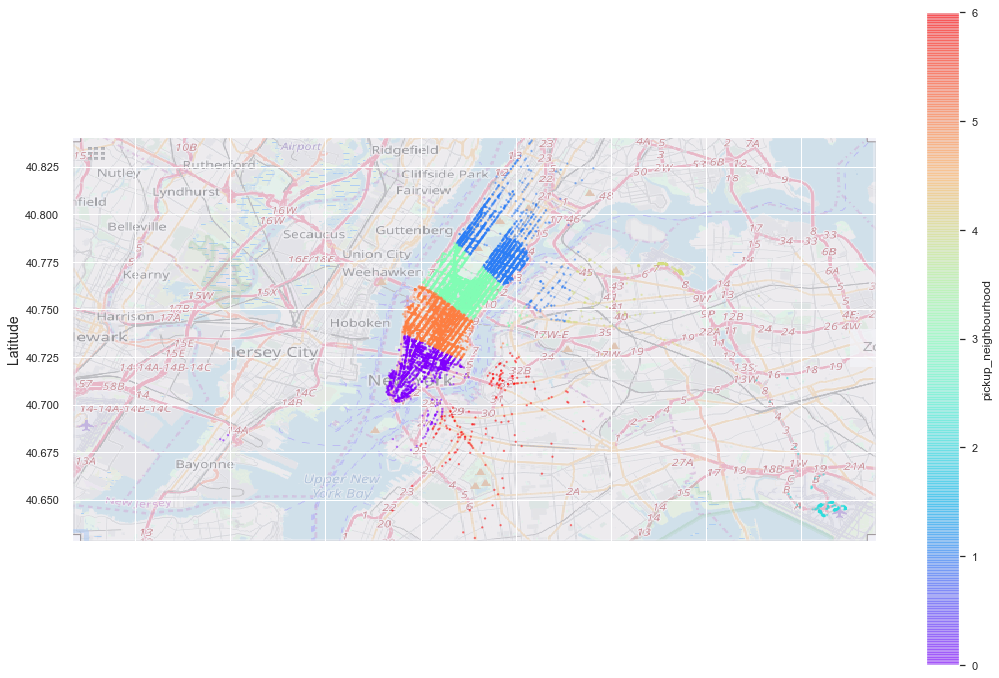

In [915]:
df_coordinates.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4, 
                      figsize=(18,12), s = 2, c ='pickup_neighbourhood', cmap=plt.get_cmap('rainbow'))
plt.imshow(map_, extent=[-74.1831, -73.7608, 40.6285, 40.8408], alpha=0.4)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

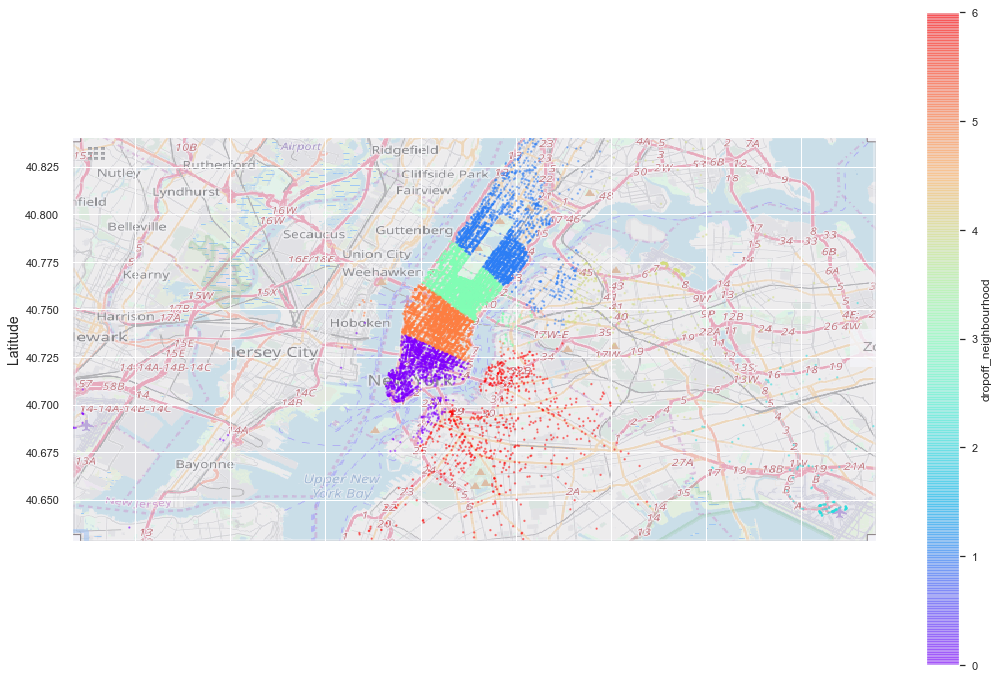

In [916]:
df_coordinates.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', alpha=0.4, 
                      figsize=(18,12), s = 2, c ='dropoff_neighbourhood', cmap=plt.get_cmap('rainbow'))
plt.imshow(map_, extent=[-74.1831, -73.7608, 40.6285, 40.8408], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

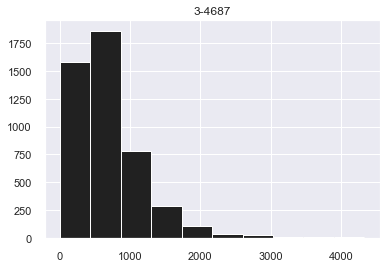

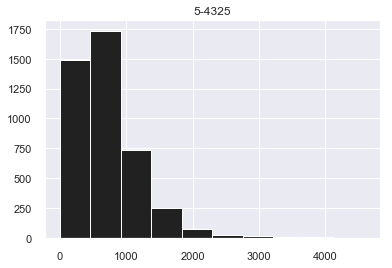

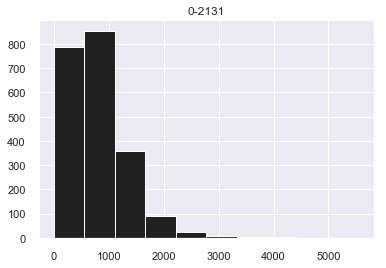

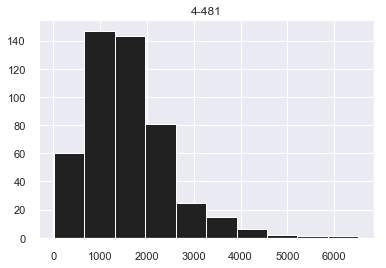

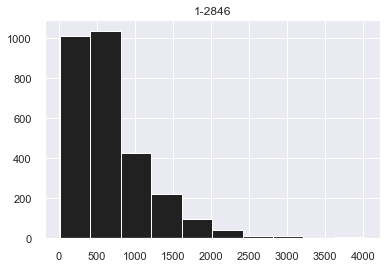

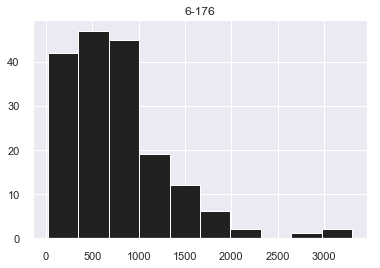

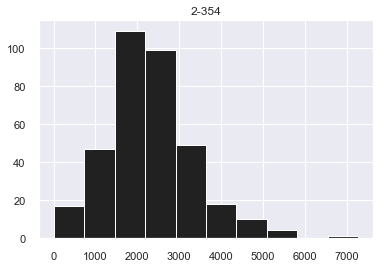

In [917]:
for cluster in df_coordinates.pickup_neighbourhood.unique():
    df_coordinates[df_coordinates['pickup_neighbourhood']==cluster].trip_duration.hist()
    plt.title(str(cluster) + "-" + str(df_coordinates[df_coordinates['pickup_neighbourhood']==cluster].shape[0]))
    plt.show()

Create distance column from pickup to dropoff:

In [918]:
def pandasDistance(row):

    return geopy.distance.distance((row.pickup_latitude, row.pickup_longitude), 
                                   (row.dropoff_latitude, row.dropoff_longitude)).km 

df_coordinates['distance_km'] =  df_coordinates.apply(lambda r: pandasDistance(r), axis=1)

In [919]:
df_coordinates.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_neighbourhood,dropoff_neighbourhood,distance_km
801893,id3039343,2,2016-01-28 12:51:25,2016-01-28 12:56:56,1,-73.968468,40.759102,-73.956718,40.764572,N,331,3,1,1.163287
1393231,id1879249,2,2016-01-20 11:49:33,2016-01-20 12:12:11,1,-73.991409,40.747906,-73.873299,40.774281,N,1358,5,4,10.394245
807040,id0798906,2,2016-01-28 19:07:04,2016-01-28 19:15:38,1,-74.005226,40.727737,-73.995499,40.739071,N,514,0,5,1.503064
1339371,id1703230,2,2016-01-20 08:57:58,2016-01-20 09:17:05,1,-74.005074,40.719116,-73.989830,40.751698,N,1147,0,5,3.840413
1193026,id2152931,2,2016-01-21 00:33:16,2016-01-21 01:08:15,1,-74.001053,40.716652,-73.950073,40.761452,N,2099,0,1,6.579694


### Further cleaning & data engineering for 2nd clustering

Drop store_and_fwd_flag & vendor_id columns as they are not significant for the clustering, and drop all latitude & longitude information as it's now represented by the cluster information

In [920]:
df_datetime = df_coordinates.copy()

In [921]:
df_datetime.drop(['id', 'vendor_id', 'pickup_longitude', 'pickup_latitude',
               'dropoff_longitude', 'dropoff_latitude'], inplace=True, axis=1)

Feature engineering on datetime: convert pick up and drop off dates to datetime

In [922]:
def get_data(dt):
    return [dt.day_name(), dt.hour]

df_datetime['pickup'] = df_datetime.pickup_datetime.map(get_data)
df_datetime['dropoff'] = df_datetime.dropoff_datetime.map(get_data)

In [923]:
df_datetime.head()

,pickup_datetime,dropoff_datetime,passenger_count,store_and_fwd_flag,trip_duration,pickup_neighbourhood,dropoff_neighbourhood,distance_km,pickup,dropoff
801893,2016-01-28 12:51:25,2016-01-28 12:56:56,1,N,331,3,1,1.163287,"[Thursday, 12]","[Thursday, 12]"
1393231,2016-01-20 11:49:33,2016-01-20 12:12:11,1,N,1358,5,4,10.394245,"[Wednesday, 11]","[Wednesday, 12]"
807040,2016-01-28 19:07:04,2016-01-28 19:15:38,1,N,514,0,5,1.503064,"[Thursday, 19]","[Thursday, 19]"
1339371,2016-01-20 08:57:58,2016-01-20 09:17:05,1,N,1147,0,5,3.840413,"[Wednesday, 8]","[Wednesday, 9]"
1193026,2016-01-21 00:33:16,2016-01-21 01:08:15,1,N,2099,0,1,6.579694,"[Thursday, 0]","[Thursday, 1]"


In [924]:
df_datetime.drop(['pickup_datetime', 'dropoff_datetime'], inplace=True, axis=1)

In [925]:
column_names = ['pickup_weekday', 'pickup_hour']

for i in range(len(column_names)):
    df_datetime[column_names[i]] = [x[i] for x in df_datetime['pickup']]

In [926]:
column_names = ['dropoff_weekday', 'dropoff_hour']

for i in range(len(column_names)):
    df_datetime[column_names[i]] = [x[i] for x in df_datetime['dropoff']]

In [927]:
df_datetime.drop(['pickup', 'dropoff'], inplace=True, axis=1)
df_datetime.head()

,passenger_count,store_and_fwd_flag,trip_duration,pickup_neighbourhood,dropoff_neighbourhood,distance_km,pickup_weekday,pickup_hour,dropoff_weekday,dropoff_hour
801893,1,N,331,3,1,1.163287,Thursday,12,Thursday,12
1393231,1,N,1358,5,4,10.394245,Wednesday,11,Wednesday,12
807040,1,N,514,0,5,1.503064,Thursday,19,Thursday,19
1339371,1,N,1147,0,5,3.840413,Wednesday,8,Wednesday,9
1193026,1,N,2099,0,1,6.579694,Thursday,0,Thursday,1


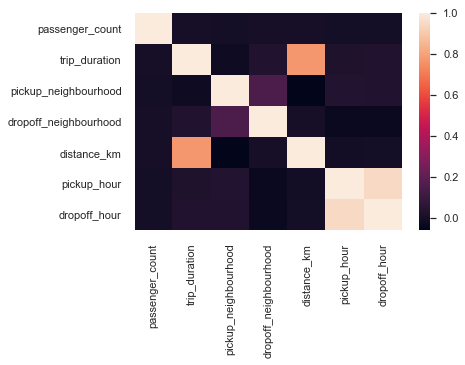

In [928]:
sns.heatmap(df_datetime.corr())

While pickup & drop off are highly correlated, as we're trying to cluster based on trip duration, we will keep this information. We will drop pick up & drop off datetime as we now have the month, hour & day columns

Plot trips by day

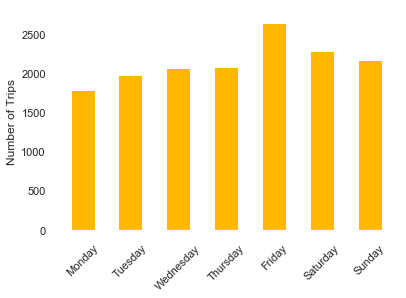

In [929]:
days_grouped = df_datetime.groupby(['pickup_weekday']).count().passenger_count.reset_index()
weekdays = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = days_grouped['pickup_weekday'].map(mapping)    
days_grouped = days_grouped.iloc[key.argsort()]

ax = days_grouped.plot(kind='bar', x='pickup_weekday', legend = False, color=["#ffb700"])
ax.set_xticklabels(labels=weekdays, rotation=45)
ax.patch.set_facecolor('white')
plt.xlabel("")
plt.ylabel("Number of Trips")
plt.show()

Plot trips by hour

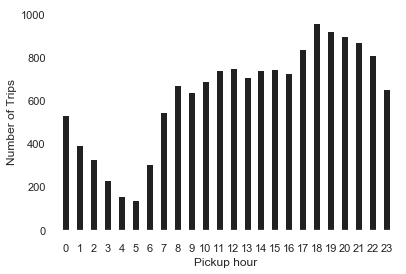

In [930]:
h_grouped = df_datetime.groupby(['pickup_hour']).count().passenger_count.reset_index()
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
mapping = {hour: i for i, hour in enumerate(hours)}
key = h_grouped['pickup_hour'].map(mapping)    
h_grouped = h_grouped.iloc[key.argsort()]

ax = h_grouped.plot(kind='bar', x='pickup_hour', legend = False, color=["#212121"])
ax.xaxis.set_tick_params(rotation=0)
ax.patch.set_facecolor('white')
plt.xlabel("Pickup hour")
plt.ylabel("Number of Trips")
plt.show()

Plot pickup hours for working days vs weekend

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


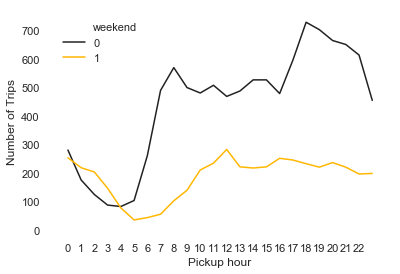

In [931]:
week_vs_wkd = df_datetime[['pickup_weekday', 'pickup_hour', 'passenger_count']]
week_vs_wkd['weekend'] = np.where(week_vs_wkd.pickup_weekday == 'Saturday', 1, 
                                  np.where(week_vs_wkd.pickup_weekday == 'Sunday', 1, 0))
h_grouped = week_vs_wkd.groupby(['weekend', 'pickup_hour']).count().passenger_count.reset_index()

hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
mapping = {hour: i for i, hour in enumerate(hours)}
key = h_grouped['pickup_hour'].map(mapping)    
h_grouped = h_grouped.iloc[key.argsort()]

colors = ["#212121","#ffb700"]
sns.set_palette(sns.color_palette(colors))
ax = sns.lineplot(x="pickup_hour", y="passenger_count", hue="weekend", data=h_grouped)
plt.xlabel("Pickup hour")
plt.ylabel("Number of Trips")
ax.patch.set_facecolor('white')
ax.set_xticks(range(0,23))
plt.show()

Do one hot encoding on day, time of day & neigbourhood fields to transform the categorical variable

In [932]:
df_dummies = pd.get_dummies(data=df_datetime, columns=['passenger_count', 'store_and_fwd_flag', 
                                                      'pickup_neighbourhood', 'dropoff_neighbourhood',
                                                      'pickup_weekday', 'pickup_hour', 'dropoff_weekday', 
                                                        'dropoff_hour'])

In [933]:
df_dummies.drop('trip_duration', inplace=True, axis=1)

In [934]:
df_dummies.shape

(15000, 85)

### K-Means Clustering

Do further clustering for the new dataset to search for clusters based on pickup & dropoff time/day

Use elbow curve for cluster number

In [935]:
df_ML = df_dummies.copy()

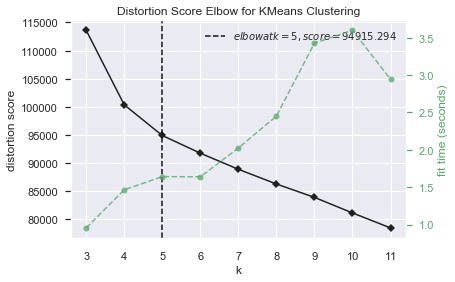

In [814]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,12), metric='distortion') #distortion=inertia
visualizer.fit(df_ML)
visualizer.poof()

In [936]:
kmeans = KMeans(n_clusters=5, random_state=8)
km1_clusters = kmeans.fit(df_ML)
labels_km1 = km1_clusters.predict(df_ML)

In [937]:
score_km1 = silhouette_score(df_ML, labels_km1, metric='euclidean')
score_km1

0.12794069453047227

In [938]:
df_ML['clusters_km1'] =km1_clusters.labels_
df['clusters_km1'] =km1_clusters.labels_

Plot pickup date vs trip duration

Text(0, 0.5, 'Trip duration, min')

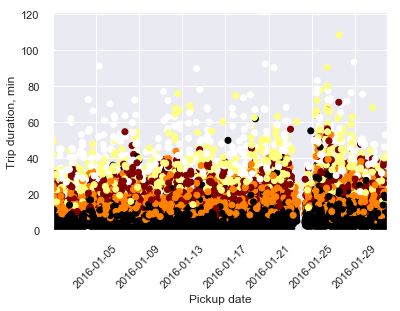

In [939]:
plt.scatter(df.pickup_datetime, df.trip_duration/60, c = df.clusters_km1, cmap=plt.get_cmap('afmhot')) 
plt.xticks(rotation=45)
plt.axis([df.pickup_datetime.min(),df.pickup_datetime.max(), 0, df.trip_duration.max()/60])
plt.xlabel("Pickup date")
plt.ylabel("Trip duration, min")

### Apply PCA to reduce to 2 components

In [940]:
#Reducing the dimensionality of the data to make it visualizable
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(df_dummies) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2']

### Apply k-means to PCA dataset

In [941]:
df_ML2 = X_principal.copy()

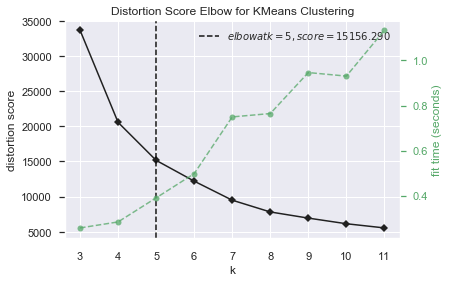

In [821]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,12), metric='distortion') #distortion=inertia
visualizer.fit(df_ML2)
visualizer.poof()

In [942]:
kmeans_km2 = KMeans(n_clusters=5)
km2_clusters = kmeans_km2.fit(df_ML2)
labels_km2 =km2_clusters.predict(df_ML2)

In [943]:
score_km2 = silhouette_score(df_ML2, labels_km2, metric='euclidean')
score_km2

0.43849462322729393

In [944]:
df_ML2['clusters_km2'] = km2_clusters.labels_
df['clusters_km2'] = km2_clusters.labels_

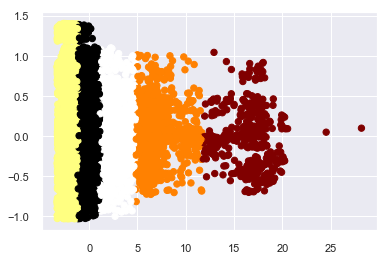

In [945]:
plt.scatter(df_ML2.P1 , df_ML2.P2, c=labels_km2, s=40, cmap='afmhot') 

### DBscan

In [946]:
df_ML3 = df_dummies.copy()

In [947]:
# Building the clustering model
clusters_db1 = DBSCAN(eps = 2, min_samples = 500).fit(df_ML3) 
labels_db1 = clusters_db1.labels_

In [948]:
score_db1 = silhouette_score(df_ML3, clusters_db1.labels_, metric='euclidean')
score_db1

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [949]:
df_ML3['clusters_db1'] = clusters_db1.labels_
df['clusters_db1'] = clusters_db1.labels_

[Timestamp('2016-01-01 00:05:07'), Timestamp('2016-01-31 23:58:12'), 0, 7271]

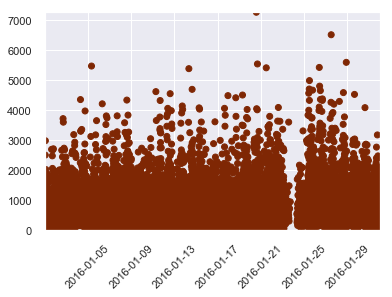

In [950]:
plt.scatter(df.pickup_datetime, df.trip_duration, c = df.clusters_db1, cmap=plt.get_cmap('Oranges_r')) 
plt.xticks(rotation=45)
plt.axis([df.pickup_datetime.min(),df.pickup_datetime.max(), 0, df.trip_duration.max()])

In [951]:
df.clusters_db1.value_counts()

-1    15000
Name: clusters_db1, dtype: int64

### DBscan using PCA dataframe

In [952]:
df_ML4 = X_principal.copy()

In [953]:
# Building the clustering model
clusters_db2 = DBSCAN(eps = 1.5, min_samples = 300).fit(df_ML4) 
labels_db2 = clusters_db2.labels_

In [954]:
score_db2 = silhouette_score(df_ML4, clusters_db2.labels_, metric='euclidean')
score_db2

0.8132372025859816

In [955]:
df_ML4['clusters_db2'] = clusters_db2.labels_
df['clusters_db2'] = clusters_db2.labels_

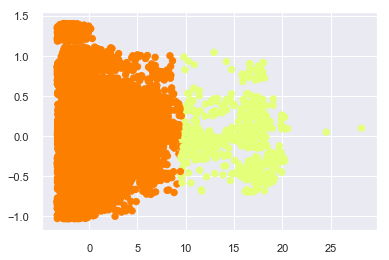

In [956]:
plt.scatter(df_ML4.P1 , df_ML4.P2, c=labels_db2, s=40, cmap='Wistia') 

### Gaussian Mixture

In [957]:
df_ML5 = df_dummies.copy()

In [958]:
gmm1 = mixture.GaussianMixture(n_components=5).fit(df_ML5)
labels_gm1 = gmm1.predict(df_ML5)

In [959]:
score_gm1 = silhouette_score(df_ML5, labels_gm1, metric='euclidean')
score_gm1

0.03243384306757326

In [960]:
df_ML5['clusters_gm1'] = labels_gm1
df['clusters_gm1'] = labels_gm1

Text(0, 0.5, 'Trip duration, min')

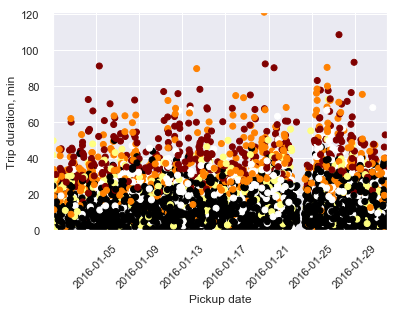

In [961]:
plt.scatter(df.pickup_datetime, df.trip_duration/60, c = df.clusters_gm1, cmap=plt.get_cmap('afmhot')) 
plt.xticks(rotation=45)
plt.axis([df.pickup_datetime.min(),df.pickup_datetime.max(), 0, df.trip_duration.max()/60])
plt.xlabel("Pickup date")
plt.ylabel("Trip duration, min")

### Gaussian Mixture using PCA dataframe

In [962]:
df_ML6 = X_principal.copy()

In [963]:
gmm2 = mixture.GaussianMixture(n_components=5).fit(df_ML6)
labels_gm2 = gmm2.predict(df_ML6)

In [964]:
score_gm2 = silhouette_score(df_ML6, labels_gm2, metric='euclidean')
score_gm2

0.4276327974708888

In [965]:
df_ML6['clusters_gm2'] = labels_gm2
df['clusters_gm2'] = labels_gm2

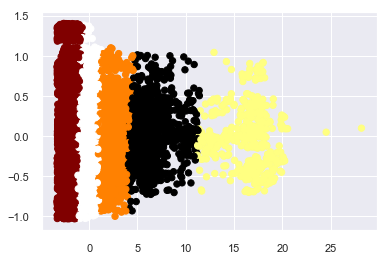

In [966]:
plt.scatter(df_ML6.P1 , df_ML6.P2, c=labels_gm2, s=40, cmap='afmhot')

In [967]:
df_datetime['clusters_km2'] = km2_clusters.labels_
df_datetime['clusters_gm2'] = labels_gm2

## Hierarchical clustering

In [968]:
df_ML7 = df_dummies.copy()

In [969]:
hier_clust = AgglomerativeClustering(linkage='ward')
df_hier = hier_clust.fit(df_ML7)

In [970]:
labels_hier = df_hier.labels_

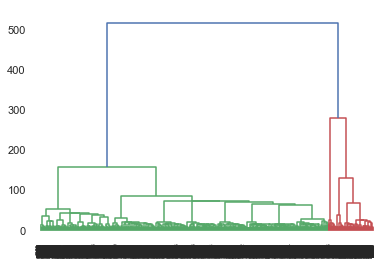

In [872]:
dendrogram = sch.dendrogram(sch.linkage(df_ML7, method='ward'))

In [971]:
score_hier = silhouette_score(df_ML7, labels_hier, metric='euclidean')
score_hier

0.7068474853724507

In [972]:
df_ML7['clusters_hier'] = labels_hier
df['clusters_hier'] = labels_hier
df_datetime['clusters_hier'] = labels_hier

Text(0, 0.5, 'Trip duration, min')

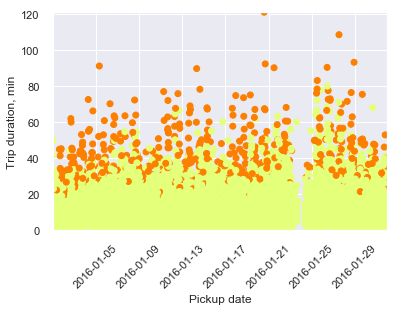

In [973]:
plt.scatter(df.pickup_datetime, df.trip_duration/60, c = df.clusters_hier, cmap=plt.get_cmap('Wistia')) 
plt.xticks(rotation=45)
plt.axis([df.pickup_datetime.min(),df.pickup_datetime.max(), 0, df.trip_duration.max()/60])
plt.xlabel("Pickup date")
plt.ylabel("Trip duration, min")

Text(0, 0.5, 'Trip duration, min')

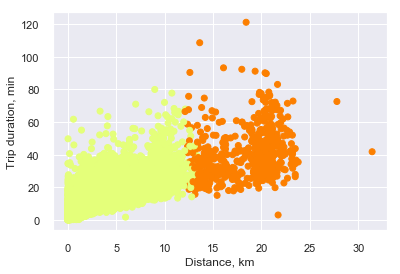

In [974]:
plt.scatter(df_datetime.distance_km, df_datetime.trip_duration/60, c=df_datetime.clusters_hier, 
            cmap=plt.get_cmap('Wistia')) 
plt.xlabel("Distance, km")
plt.ylabel("Trip duration, min")

## Hierarchical clustering on PCA df

In [975]:
df_ML8 = X_principal.copy()

In [976]:
hier_clust2 = AgglomerativeClustering(linkage='ward')
df_hier2 = hier_clust2.fit(df_ML8)
labels_hier2 = df_hier2.labels_

In [978]:
score_hier2 = silhouette_score(df_ML8, labels_hier2, metric='euclidean')
score_hier2

0.7492411767680953

In [979]:
df_ML8['clusters_hier2'] = labels_hier
df['clusters_hier2'] = labels_hier
df_datetime['clusters_hier2'] = labels_hier

Text(0, 0.5, 'Trip duration, min')

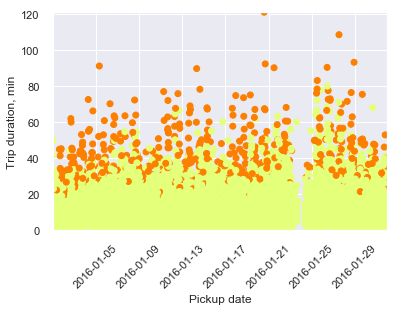

In [980]:
plt.scatter(df.pickup_datetime, df.trip_duration/60, c = df.clusters_hier2, cmap=plt.get_cmap('Wistia')) 
plt.xticks(rotation=45)
plt.axis([df.pickup_datetime.min(),df.pickup_datetime.max(), 0, df.trip_duration.max()/60])
plt.xlabel("Pickup date")
plt.ylabel("Trip duration, min")

Text(0, 0.5, 'Trip duration, min')

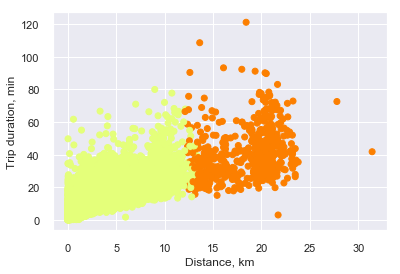

In [981]:
plt.scatter(df_datetime.distance_km, df_datetime.trip_duration/60, c=df_datetime.clusters_hier2, 
            cmap=plt.get_cmap('Wistia')) 
plt.xlabel("Distance, km")
plt.ylabel("Trip duration, min")

## Create features to explore results

In [982]:
df_datetime['trip_duration_min'] = df_datetime.trip_duration/60

In [983]:
# Create labels for trip duration
min_labels = ['<10min', '10-20min', '21-40min', '41-60min', '>1h']
cutoffs = [-1, 10, 20, 40, 60, 300]
df_datetime['duration_labels_min'] = pd.cut(df_datetime.trip_duration_min, cutoffs, labels=min_labels)

In [984]:
# Create labels for distance
distance_labels = ['<2', '2-4', '5-7', '8-11', '12-16', '>16']
cutoffs = [-1, 2, 4, 7, 11, 16, 100]
df_datetime['distance_labels_km'] = pd.cut(df_datetime.distance_km, cutoffs, labels=distance_labels)

In [985]:
df_datetime.head()

,passenger_count,store_and_fwd_flag,trip_duration,pickup_neighbourhood,dropoff_neighbourhood,distance_km,pickup_weekday,pickup_hour,dropoff_weekday,dropoff_hour,clusters_km2,clusters_gm2,clusters_hier,clusters_hier2,trip_duration_min,duration_labels_min,distance_labels_km
801893,1,N,331,3,1,1.163287,Thursday,12,Thursday,12,3,1,0,0,5.516667,<10min,<2
1393231,1,N,1358,5,4,10.394245,Wednesday,11,Wednesday,12,2,0,0,0,22.633333,21-40min,8-11
807040,1,N,514,0,5,1.503064,Thursday,19,Thursday,19,3,1,0,0,8.566667,<10min,<2
1339371,1,N,1147,0,5,3.840413,Wednesday,8,Wednesday,9,0,4,0,0,19.116667,10-20min,2-4
1193026,1,N,2099,0,1,6.579694,Thursday,0,Thursday,1,4,2,0,0,34.983333,21-40min,5-7


## K-means2 results

In [986]:
pd.crosstab(df_datetime.duration_labels_min,df_datetime.clusters_km2)

clusters_km2,0,1,2,3,4
duration_labels_min,,,,,
<10min,1064,1,0,6039,54
10-20min,2526,9,160,1662,900
21-40min,569,203,560,147,747
41-60min,8,146,103,5,18
>1h,2,51,24,1,1


Text(0, 0.5, 'Trip duration, min')

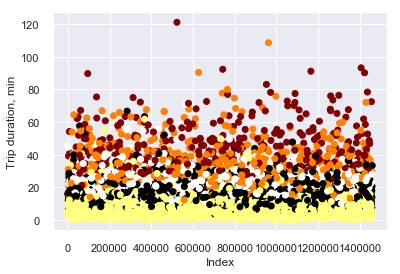

In [987]:
plt.scatter(df_datetime.index, df_datetime.trip_duration/60, c=df_datetime.clusters_km2, 
            cmap=plt.get_cmap('afmhot')) 
plt.xlabel("Index")
plt.ylabel("Trip duration, min")

In [988]:
pd.crosstab(df_datetime.distance_labels_km,df_datetime.clusters_km2)

clusters_km2,0,1,2,3,4
distance_labels_km,,,,,
<2,0,0,0,7373,0
2-4,3755,0,0,481,0
5-7,414,0,0,0,1443
8-11,0,0,607,0,277
12-16,0,32,240,0,0
>16,0,378,0,0,0


Text(0, 0.5, 'Trip duration, min')

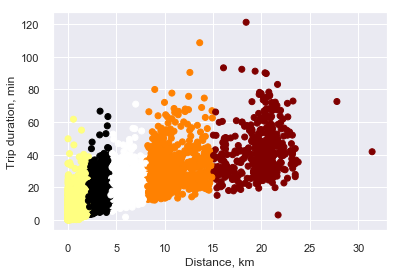

In [989]:
plt.scatter(df_datetime.distance_km, df_datetime.trip_duration/60, c=df_datetime.clusters_km2, 
            cmap=plt.get_cmap('afmhot')) 
plt.xlabel("Distance, km")
plt.ylabel("Trip duration, min")

In [990]:
pd.crosstab(df_datetime.pickup_weekday, df_datetime.clusters_km2)

clusters_km2,0,1,2,3,4
pickup_weekday,,,,,
Friday,768,70,140,1360,307
Monday,452,67,109,954,201
Saturday,689,48,102,1178,265
Sunday,617,62,132,1089,272
Thursday,569,44,124,1096,244
Tuesday,529,61,118,1043,227
Wednesday,545,58,122,1134,204


In [991]:
pd.crosstab(df_datetime.pickup_neighbourhood, df_datetime.clusters_km2)

clusters_km2,0,1,2,3,4
pickup_neighbourhood,,,,,
0,665,22,123,896,425
1,871,19,78,1543,335
2,9,271,52,9,13
3,1344,59,135,2743,406
4,29,10,323,44,75
5,1199,29,125,2540,432
6,52,0,11,79,34


## GMM2 results

In [992]:
pd.crosstab(df_datetime.distance_labels_km, df_datetime.clusters_gm2)

clusters_gm2,0,1,2,3,4
distance_labels_km,,,,,
<2,0,7373,0,0,0
2-4,0,542,0,0,3694
5-7,0,0,1609,0,248
8-11,753,0,131,0,0
12-16,224,0,0,48,0
>16,0,0,0,378,0


Text(0, 0.5, 'Trip duration, min')

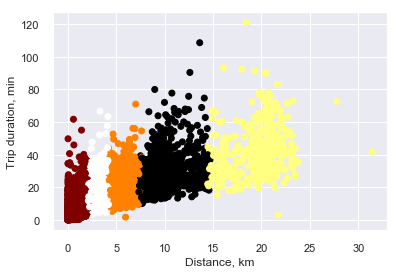

In [993]:
plt.scatter(df_datetime.distance_km, df_datetime.trip_duration/60, c=df_datetime.clusters_gm2, 
            cmap=plt.get_cmap('afmhot')) 
plt.xlabel("Distance, km")
plt.ylabel("Trip duration, min")

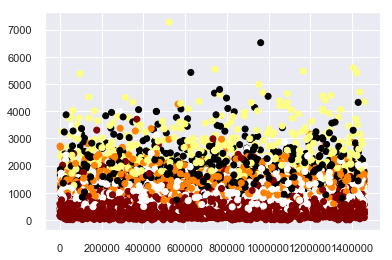

In [994]:
plt.scatter(df_datetime.index, df_datetime.trip_duration, c=df_datetime.clusters_gm2, 
            cmap=plt.get_cmap('afmhot')) 

In [995]:
pd.crosstab(df_datetime.pickup_weekday, df_datetime.clusters_gm2)

clusters_gm2,0,1,2,3,4
pickup_weekday,,,,,
Friday,161,1352,315,74,743
Monday,126,953,201,70,433
Saturday,114,1236,270,48,614
Sunday,149,1123,277,63,560
Thursday,150,1087,242,45,553
Tuesday,137,1039,234,64,504
Wednesday,140,1125,201,62,535


In [996]:
pd.crosstab(df_datetime.pickup_neighbourhood, df_datetime.clusters_gm2)

clusters_gm2,0,1,2,3,4
pickup_neighbourhood,,,,,
0,154,942,427,24,584
1,114,1491,335,20,886
2,48,8,10,278,10
3,161,2683,433,62,1348
4,343,43,55,13,27
5,144,2668,443,29,1041
6,13,80,37,0,46


In [998]:
df_datetime.clusters_km2.unique()

array([3, 2, 0, 4, 1])

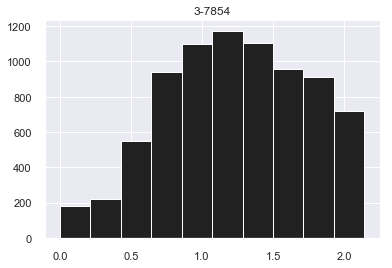

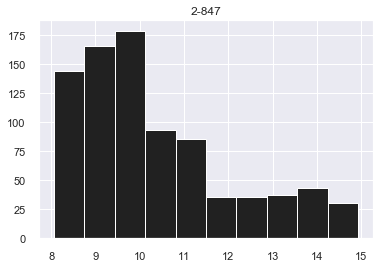

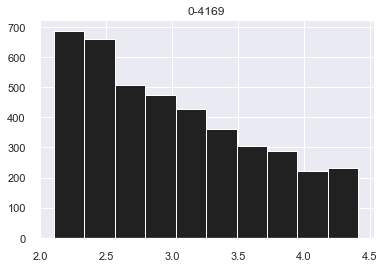

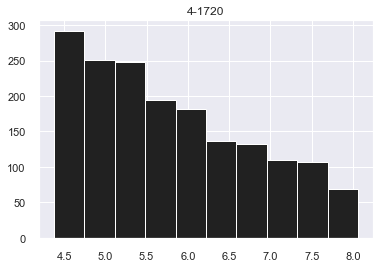

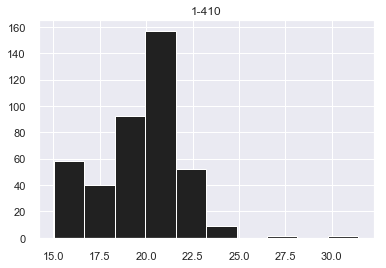

In [1003]:
for cluster in df_datetime.clusters_km2.unique():
    df_datetime[df_datetime['clusters_km2']==cluster].distance_km.hist()
    plt.title(str(cluster) + "-" + str(df_datetime[df_datetime['clusters_km2']==cluster].shape[0]))
    plt.show()